![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import collections
import re
import datetime
import json

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [3]:
def round_of_rating(number):
    # Округляем до 0.5
    return np.round(number * 2) / 2

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
df_train.info()
df_train.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [6]:
df_test.info()
df_test.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [7]:
sample_submission.info()
sample_submission.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [8]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [10]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
23329,id_8185,London,NaN,8194.0,NaN,2.0,[['Great gig venue for intimate gigs - used t....,/Restaurant_Review-g186338-d12895543-Reviews-T...,d12895543,1,5.0
46530,id_1110,Athens,"['Greek', 'Russian']",1112.0,$,2.0,"[['Spectacular', 'Amazing'], ['08/27/2016', '0...",/Restaurant_Review-g189400-d10533809-Reviews-K...,d10533809,1,5.0
1434,id_1434,Barcelona,"['Mediterranean', 'European', 'Spanish', 'Vege...",603.0,$$ - $$$,185.0,"[['Yes !', 'Nice and elegant'], ['08/27/2017',...",/Restaurant_Review-g187497-d997855-Reviews-La_...,d997855,0,0.0
34280,id_2202,Milan,['Vegetarian Friendly'],2204.0,$,33.0,"[['excellent food, friendly staff', 'Souther I...",/Restaurant_Review-g187849-d10185679-Reviews-L...,d10185679,1,4.5
38150,id_5484,Barcelona,NaN,5485.0,NaN,30.0,"[['Excellence in cooking simple food', 'Good f...",/Restaurant_Review-g187497-d5795295-Reviews-Ca...,d5795295,1,3.5


# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

# ***Number of Reviews***

In [11]:
# Для примера я возьму столбец Number of Reviews
data['Number_of_Reviews_NAN'] = pd.isna(data['Number of Reviews']).astype('uint8')
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
data['Number of Reviews'].fillna(0, inplace=True) 

# *Reviews*

In [12]:
data['Reviews_NaN'] = pd.isna(data['Reviews']).astype('uint8')
# заполним пропуски значением '[[], []]'
data['Reviews'] = data['Reviews'].fillna('[[], []]')

# ***Cuisine Style***

In [13]:
data['Cuisine_Style_NaN'] = pd.isna(data['Cuisine Style']).astype('uint8') 
# заполним пропуски значением 'other_style'
data['Cuisine Style'] = data['Cuisine Style'].fillna("['Other']")

# ***Price Range***

In [14]:
# сохраним информацию о пропусках чтобы не потерять
data['Price_Range_NaN'] = pd.isna(data['Price Range']).astype('uint8') 
# поэтому заполняем пропуски 0
data['Price Range'].fillna(0, inplace=True) 

# **2. Обработка признаков**

**Restaurant_id**

In [15]:
data.Restaurant_id.value_counts()

id_871      19
id_436      19
id_227      19
id_633      19
id_430      18
            ..
id_12528     1
id_6615      1
id_9088      1
id_13841     1
id_13289     1
Name: Restaurant_id, Length: 13094, dtype: int64

Возможно id ресторана проставляется в соответствии с рейтингом

In [16]:
def change_id(x):
    if 'id_' in str(x):
        return str(x).replace('id_', '')
    else: return x
    
data['Restaurant_id'] = data['Restaurant_id'].apply(change_id)
data['Restaurant_id'] = pd.to_numeric(data['Restaurant_id'])

**Признак City**

In [17]:
data.City.value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

In [18]:
data['City_origin'] = data['City']

**Cuisine Style**

In [19]:
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: re.findall('\w+\s*\w+\s*\w+', str(x)))

**Price Range**

In [20]:
# заполним значения в переменной по словарю
dict_Price_Range = {'$':1,'$$ - $$$':2,'$$$$':3}
data['Price Range']=data['Price Range'].map(lambda x: dict_Price_Range.get(x,x))

data['Price Range'].value_counts()

2    23041
0    17361
1     7816
3     1782
Name: Price Range, dtype: int64

**Reviews**

In [21]:
def fill_na_reviews(x):
    if x == '[[], []]':
        return None
    else:
        return x
    
data['Reviews'] = data['Reviews'].fillna(fill_na_reviews)

In [22]:
# выделим даты из обзора
data['Review_date'] = data.Reviews.apply(lambda x : [0] if pd.isna(x) else x[2:-2].split('], [')[1][1:-1].split("', '"))

**URL_TA**

In [23]:
data.drop(['URL_TA'], axis=1, inplace=True)

**ID_TA**

In [24]:
def change_id_TA(x):
    if 'd' in str(x):
        return str(x).replace('d', '')
    else: return x

# заменим на число
data['ID_TA'] = data['ID_TA'].apply(change_id_TA)
data['ID_TA'] = pd.to_numeric(data['ID_TA'])

# ***Генерация признаков***

In [25]:
data.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'ID_TA', 'sample', 'Rating',
       'Number_of_Reviews_NAN', 'Reviews_NaN', 'Cuisine_Style_NaN',
       'Price_Range_NaN', 'City_origin', 'Review_date'],
      dtype='object')

In [26]:
# встречаемые кухни
cuisines = set()

for i in data['Cuisine Style']:
    for j in i:
        cuisines.add(j)

In [27]:
cuisines

{'Afghani',
 'African',
 'Albanian',
 'American',
 'Arabic',
 'Argentinean',
 'Armenian',
 'Asian',
 'Australian',
 'Austrian',
 'Azerbaijani',
 'Balti',
 'Bangladeshi',
 'Bar',
 'Barbecue',
 'Belgian',
 'Brazilian',
 'Brew Pub',
 'British',
 'Burmese',
 'Cafe',
 'Cajun',
 'Cambodian',
 'Canadian',
 'Caribbean',
 'Caucasian',
 'Central American',
 'Central Asian',
 'Central European',
 'Chilean',
 'Chinese',
 'Colombian',
 'Contemporary',
 'Creole',
 'Croatian',
 'Cuban',
 'Czech',
 'Danish',
 'Delicatessen',
 'Diner',
 'Dutch',
 'Eastern European',
 'Ecuadorean',
 'Egyptian',
 'Ethiopian',
 'European',
 'Fast Food',
 'Filipino',
 'French',
 'Fujian',
 'Fusion',
 'Gastropub',
 'Georgian',
 'German',
 'Gluten Free Options',
 'Greek',
 'Grill',
 'Halal',
 'Hawaiian',
 'Healthy',
 'Hungarian',
 'Indian',
 'Indonesian',
 'International',
 'Irish',
 'Israeli',
 'Italian',
 'Jamaican',
 'Japanese',
 'Korean',
 'Kosher',
 'Latin',
 'Latvian',
 'Lebanese',
 'Malaysian',
 'Mediterranean',
 'Mex

In [28]:
# частота встречаемости
type_cousine = {}  # создаём пустой словарь для хранения информации о кухнях
for item in cuisines:  # перебираем список кухонь
    type_cousine[item] = 0 # добавляем в словарь ключ, соответствующий очередной кухне

for i in data['Cuisine Style']:   # перебираем список кухонь
    for j in i:   # и список кухонь в каждом ресторане
        type_cousine[j] += 1   # увеличиваем значение нужного ключа в словаре на 1

In [29]:
type_cousine

{'Minority Chinese': 12,
 'Latvian': 1,
 'Vietnamese': 622,
 'Central American': 168,
 'Hungarian': 444,
 'Southwestern': 24,
 'Scottish': 199,
 'Romanian': 13,
 'British': 1992,
 'Portuguese': 1385,
 'Salvadoran': 1,
 'Yunnan': 2,
 'Cambodian': 22,
 'Scandinavian': 449,
 'Ethiopian': 51,
 'Brazilian': 152,
 'Bangladeshi': 100,
 'Egyptian': 24,
 'Peruvian': 130,
 'Kosher': 56,
 'Jamaican': 36,
 'Korean': 206,
 'Norwegian': 96,
 'Nepali': 121,
 'Asian': 3786,
 'Persian': 77,
 'Halal': 773,
 'African': 193,
 'Afghani': 27,
 'Malaysian': 38,
 'American': 1642,
 'International': 1966,
 'Brew Pub': 299,
 'Australian': 36,
 'Danish': 225,
 'Taiwanese': 30,
 'Colombian': 30,
 'Mediterranean': 7820,
 'Caribbean': 124,
 'Canadian': 7,
 'Pub': 3058,
 'Latin': 373,
 'Street Food': 336,
 'Pizza': 3502,
 'Contemporary': 652,
 'Cuban': 32,
 'Belgian': 335,
 'Russian': 66,
 'Hawaiian': 23,
 'South American': 490,
 'Turkish': 574,
 'Native American': 5,
 'Japanese': 1860,
 'German': 820,
 'Polish': 45

In [30]:
# топ кухонь
top_cuisine = []
for key, value in type_cousine.items():
    if value > 3000:
        top_cuisine.append(key)
top_cuisine

['Asian',
 'Mediterranean',
 'Pub',
 'Pizza',
 'Gluten Free Options',
 'Vegan Options',
 'European',
 'Vegetarian Friendly',
 'Italian',
 'Other',
 'Spanish',
 'French',
 'Bar']

In [31]:
def most_popular_cuisine(x):
    for element in top_cuisine:
        if element in x:
            return 1
        else:
            continue
            
# новое поле "Наличие популярной кухни"            
data['most_popular_cuisine'] = data['Cuisine Style'].apply(most_popular_cuisine)

In [32]:
data['most_popular_cuisine'].fillna(0, inplace = True)

In [33]:
# добавим новый признак "Количество кухонь в ресторане"
data['cuisine_counts'] = data['Cuisine Style'].apply(lambda x: len(x))

**Reviews**

In [34]:
# максимальная дата отзыва
data['max_Review_date'] = pd.to_datetime(data['Review_date'].apply(lambda x: max(x)))
# первая дата отзыва
data['first_Review_date'] = pd.to_datetime(data['Review_date'].apply(lambda x : x[0]))
# вторая дата отзыва
data['second_Review_date'] = pd.to_datetime(data['Review_date'].apply(lambda x: x[1] if len(x) == 2 else ''))
# новое поле "разница в датах отзыва"
data['rew_delta'] = np.abs(data['first_Review_date'] - data['second_Review_date'])
#  "разница в датах отзыва" в днях
data['rew_delta'] = data['rew_delta'].apply(lambda x: x.days)

data['rew_delta'].fillna(value=round(data.rew_delta.mean()), inplace=True)

# новое поле "разница между текущей датой и последней датой отзывы"
data['cur_rew_delta'] = datetime.datetime.now() - data['max_Review_date']
data['cur_rew_delta'] = data['cur_rew_delta'].apply(lambda x: x.days)
data['cur_rew_delta'].fillna(value=round(data.cur_rew_delta.mean()), inplace=True)

# пустые значения
data['cur_rew_delta'] = data['cur_rew_delta'].fillna(data['cur_rew_delta'].median())
data['rew_delta'] = data['rew_delta'].fillna(data['rew_delta'].median())

In [35]:
data.drop(['max_Review_date','first_Review_date','second_Review_date'], axis=1, inplace=True)

**City Origin**

In [36]:
data['City_origin'].value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City_origin, dtype: int64

In [37]:
dict_Сity_population= {'London' : 8908, 'Paris' : 2206, 'Madrid' : 3223, 'Barcelona' : 1620, 
                        'Berlin' : 6010, 'Milan' : 1366, 'Rome' : 2872, 'Prague' : 1308, 
                        'Lisbon' : 506, 'Vienna' : 1888, 'Amsterdam' : 860, 'Brussels' : 179, 
                        'Hamburg' : 1841, 'Munich' : 1457, 'Lyon' : 506, 'Stockholm' : 961, 
                        'Budapest' : 1752, 'Warsaw' : 1764, 'Dublin' : 553, 
                        'Copenhagen' : 616, 'Athens' : 665, 'Edinburgh' : 513, 
                        'Zurich' : 415, 'Oporto' : 240, 'Geneva' : 201, 'Krakow' : 769, 
                        'Oslo' : 681, 'Helsinki' : 643, 'Bratislava' : 426, 
                        'Luxembourg' : 119, 'Ljubljana' : 284}

# Население города из справочника
data['Сity_population'] = data.apply(lambda row: dict_Сity_population[row['City_origin']], axis = 1)

In [38]:
# Ресторанов на город
data['Rest_Cnt_Per_City'] = data['City_origin'].map(data.groupby('City_origin')['Restaurant_id'].count().to_dict())
# Людей на ресторан
data['Cnt_rest_per_person'] = data['Сity_population']/data['Rest_Cnt_Per_City']

In [39]:
# Рейтинг на город
data['Ranking_per_city'] = data['Ranking'] / data['Cnt_rest_per_person']

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 24 columns):
Restaurant_id            50000 non-null int64
City                     50000 non-null object
Cuisine Style            50000 non-null object
Ranking                  50000 non-null float64
Price Range              50000 non-null int64
Number of Reviews        50000 non-null float64
Reviews                  50000 non-null object
ID_TA                    50000 non-null int64
sample                   50000 non-null int64
Rating                   50000 non-null float64
Number_of_Reviews_NAN    50000 non-null uint8
Reviews_NaN              50000 non-null uint8
Cuisine_Style_NaN        50000 non-null uint8
Price_Range_NaN          50000 non-null uint8
City_origin              50000 non-null object
Review_date              50000 non-null object
most_popular_cuisine     50000 non-null float64
cuisine_counts           50000 non-null int64
rew_delta                50000 non-null float64
cu

# EDA

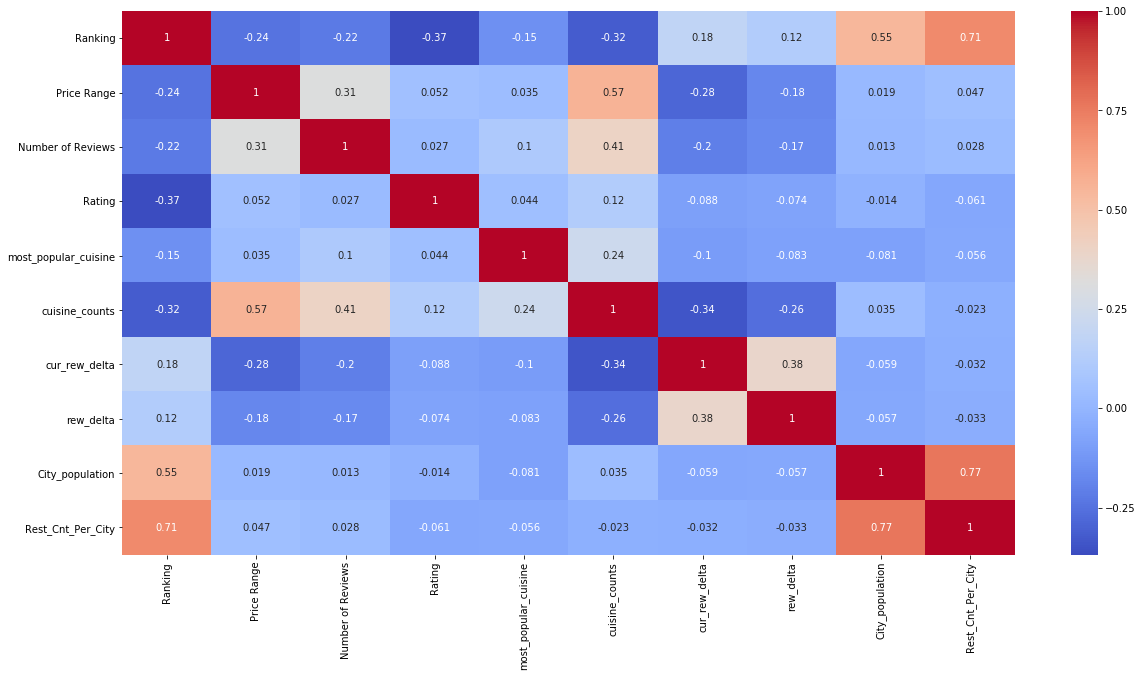

In [41]:
correlation = data[data['sample'] == 1][['Ranking', 'Price Range','Number of Reviews', 'Rating','most_popular_cuisine', 
                                         'cuisine_counts', 'cur_rew_delta', 'rew_delta', 'Сity_population', 'Rest_Cnt_Per_City']].corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

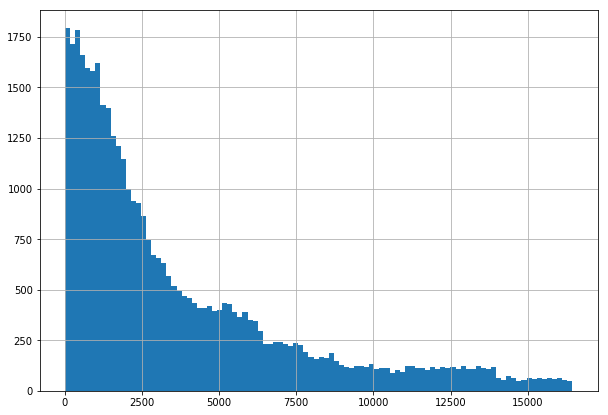

In [42]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

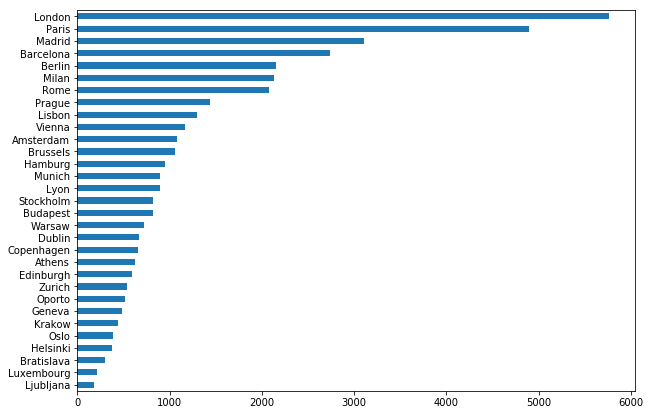

In [43]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

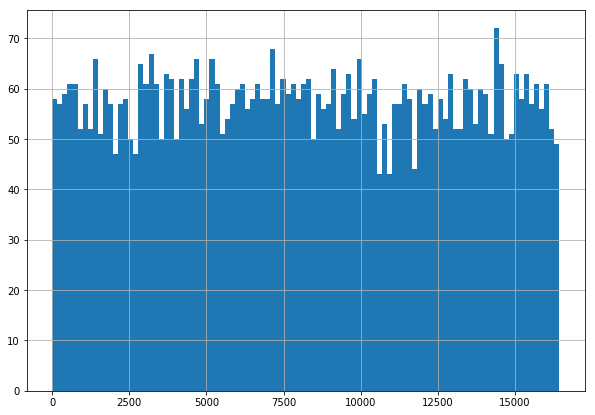

In [44]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

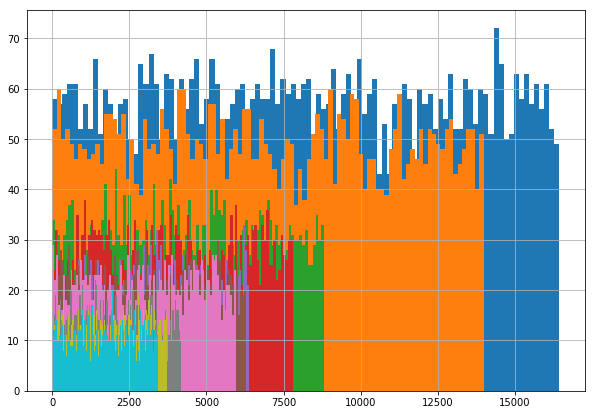

In [45]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

### Посмотрим распределение целевой переменной

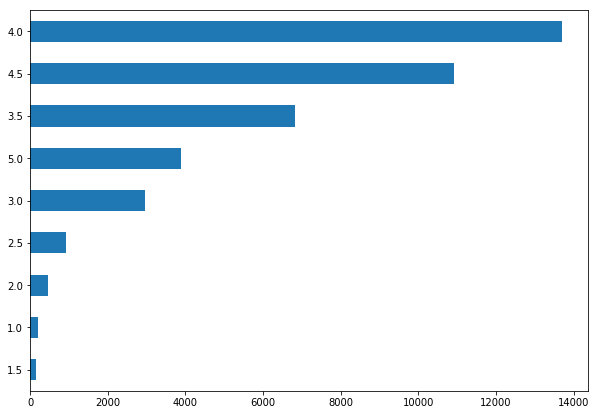

In [46]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

In [47]:
mn = data.groupby('City_origin')['Ranking'].mean()
st = data.groupby('City_origin')['Ranking'].std()
# Стандартизировать рейтинг
data['Std_Ranking'] = (data['Ranking'] - data['City_origin'].map(mn))/data['City_origin'].map(st)

# Data Preprocessing

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 25 columns):
Restaurant_id            50000 non-null int64
City                     50000 non-null object
Cuisine Style            50000 non-null object
Ranking                  50000 non-null float64
Price Range              50000 non-null int64
Number of Reviews        50000 non-null float64
Reviews                  50000 non-null object
ID_TA                    50000 non-null int64
sample                   50000 non-null int64
Rating                   50000 non-null float64
Number_of_Reviews_NAN    50000 non-null uint8
Reviews_NaN              50000 non-null uint8
Cuisine_Style_NaN        50000 non-null uint8
Price_Range_NaN          50000 non-null uint8
City_origin              50000 non-null object
Review_date              50000 non-null object
most_popular_cuisine     50000 non-null float64
cuisine_counts           50000 non-null int64
rew_delta                50000 non-null float64
cu

In [49]:
data.drop(['Restaurant_id','Cuisine_Style_NaN', 'Price_Range_NaN', 'Cuisine Style', 'Reviews', 'ID_TA', 
           'Number_of_Reviews_NAN','Reviews_NaN', 'City_origin', 'City', 'Review_date'], axis=1, inplace=True, errors='ignore')

In [50]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [51]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [52]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 13), (40000, 13), (40000, 12), (32000, 12), (8000, 12))

# Model 
Сам ML

In [53]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [54]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [55]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = round_of_rating(model.predict(X_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [56]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.175


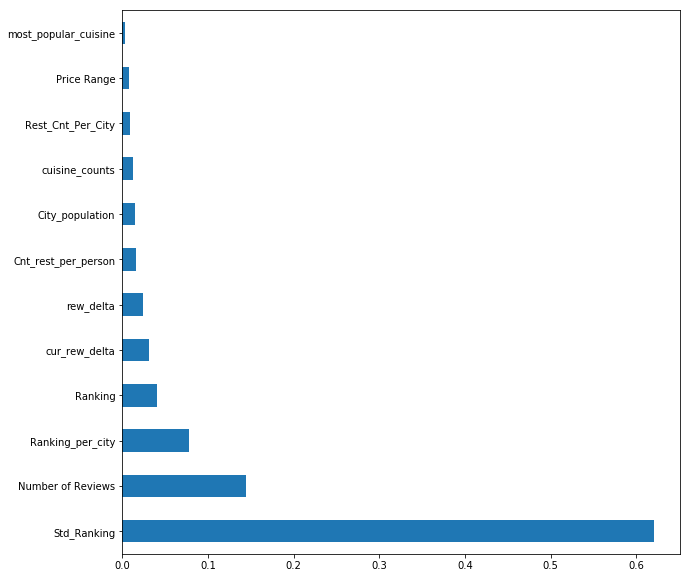

In [57]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [58]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,most_popular_cuisine,cuisine_counts,rew_delta,cur_rew_delta,Сity_population,Rest_Cnt_Per_City,Cnt_rest_per_person,Ranking_per_city,Std_Ranking
2530,667.0,2,19.0,0.0,1.0,6,36.0,1061.0,665,776,0.856959,778.333835,-0.429052
1823,3266.0,0,28.0,0.0,1.0,1,143.0,1932.0,3223,3813,0.845266,3863.871548,-0.444094
7561,3436.0,0,0.0,0.0,1.0,1,143.0,1293.0,1366,2694,0.507053,6776.415813,0.183379
1790,11163.0,0,45.0,0.0,1.0,1,71.0,1202.0,2206,6108,0.361166,30908.252040,1.045672
9539,2838.0,2,17.0,0.0,0.0,1,30.0,1027.0,2206,6108,0.361166,7857.889393,-1.015006
6774,1401.0,2,18.0,0.0,1.0,2,127.0,1148.0,6010,2705,2.221811,630.566556,-1.020822
6428,85.0,2,74.0,0.0,1.0,6,25.0,1083.0,681,488,1.395492,60.910426,-1.425567
2458,1162.0,2,266.0,0.0,0.0,2,181.0,1047.0,1366,2694,0.507053,2291.674963,-1.080375
4410,4586.0,0,2.0,0.0,1.0,1,143.0,1293.0,1366,2694,0.507053,9044.424597,0.822481
1555,13157.0,0,2.0,0.0,1.0,3,194.0,2897.0,8908,7193,1.238426,10623.967333,1.055743


In [59]:
test_data = test_data.drop(['Rating'], axis=1)

In [60]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [61]:
predict_submission = round_of_rating(model.predict(test_data))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [62]:
predict_submission

array([3. , 4.5, 4. , ..., 3. , 4.5, 4.5])

In [63]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.5
2,id_2,4.0
3,id_3,4.0
4,id_4,4.5
5,id_5,4.5
6,id_6,2.0
7,id_7,2.5
8,id_8,4.0
9,id_9,4.5


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
